In [17]:
# Imports
!pip install nfl_data_py
import nfl_data_py as nfl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error

## Data Pre-Processing

### *Groups Values by Player*

In [19]:
# Groups the players by player data
def group_data_by_player(curr_player_records, player_data):

  # Stores all player records
  player_records = curr_player_records

  # Goes through the values in the player data
  for index, curr_entry in player_data.iterrows():

    # Adds the values in the player data to the player records
    curr_player = curr_entry['player_id']

    # Adds the current player's entry to the player records if lookup is found
    if (curr_player in player_records):
      player_records[curr_player].append(curr_entry)

    # Otherwise, we create a new entry
    else:
      player_records[curr_player] = [curr_entry]

  # Returns the player_records
  return player_records

### *Imports Player Values for Each Year*

In [20]:
# Gets the player statistics by input years
def get_player_vals_by_years(training_years, is_test):

  # Creates a dictionary to store the original values for the player data
  curr_players = dict()

  # Adds the players for each years into the curr_players dictionary
  for curr_year in training_years:

    # Gets the data for the year
    curr_data = nfl.clean_nfl_data(nfl.import_seasonal_data([curr_year], 'REG'))
    curr_data = curr_data.loc[curr_data['games'] > 3]


    # Adds the current year's information to the curr_players dictionary
    curr_players = group_data_by_player(curr_players, curr_data)

  # Cuts all players who haven't played for years
  player_data = dict()

  # Adds all players with multiyear data to our final player_data
  for player in curr_players:
    if (is_test or len(curr_players[player]) > 1):
      player_data[player] = curr_players[player]

  # Returns the player data by the desired years
  return player_data

### *Sorts Player by Position*

In [21]:
# Get the player positions from the yearly rosters
def get_player_positions(curr_roster, off_pos_set):

  # Stores a dictionary for the player positions
  player_positions = dict()

  # Goes through the values in the player data
  for index, curr_entry in curr_roster.iterrows():

    # Gets the current position for each player
    curr_id = curr_entry['player_id']
    curr_pos = curr_entry['position']

    # If the player is in one of the positions we track, we add them
    if (curr_pos in off_pos_set):
      player_positions[curr_id] = curr_pos

  # Returns the player positions for each player
  return player_positions


# Sorts the players by position
def sort_players_by_position(player_positions, player_data, off_pos_set):

  # Stores the ultimate player by position directory
  players_by_position = dict()

  # Creates the starting dictionary for players within each position set
  for pos in off_pos_set:
    players_by_position[pos] = []

  # Goes through the values in the player data
  for curr_id in player_data:

    # If the player is in player_positions
    if (curr_id in player_positions):

      # Gets the position for the player
      curr_pos = player_positions[curr_id]

      # Sorts the player data into the position grouping
      #for curr_entry in player_data[curr_id]:
      players_by_position[curr_pos].append(player_data[curr_id])

  # Returns the player data by position
  return players_by_position

### *Creates the X-Y pairs for Players (X = Prev. Year Stats, Y = Current Fantasy PPR Score)*

In [22]:
# Creates the x-y pairs for prediction based on our feature variables
# X-Value -- Desired features in the current player
# Y-Value -- The Fantasy PPR Score for the Following Year divided by the number of games
#            NOTE: We make the prediction Points Per Game to limit the prediction
#            in this part of the analysis to just production. Injury status
#            and riskiness will come in at a later point in the process.
def create_x_y_pairs(curr_players, regularization_args):

  # Creates an array to store the x y pairs of the players
  x_values = []
  y_values = []

  # Loops through the players to determine the x-y pairs
  for player in curr_players:

    # Begins the year pairing
    x_year = player[0]

    # Loops through the years for the players
    for next_year in range (1, len(player), 1):

      # Adds the next year to the function
      y_year = player[next_year]

      # Adds the year score pair to the x_y_pairs for the player
      x_games = x_year['games']
      regularized_x = x_year[regularization_args]/x_games
      x_year[regularization_args] = regularized_x

      x_values.append(x_year)
      y_values.append(y_year['fantasy_points_ppr']/y_year['games'])

      # Resets the x_year to be the preceding year
      x_year = y_year

  # Returns the train and test sets
  return (x_values, y_values)

### *Creates Cleaned Data Set*

Something worth considering -- splitting test and train off of players, not year-to-year


In [23]:
# Stores all features that could be useful for a QB
full_qb_features = ['completions', 'attempts', 'passing_yards', 'passing_tds',
                    'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
                    'sack_fumbles_lost', 'passing_air_yards',
                    'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
                    'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
                    'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
                    'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions']

# Stores all features that could be useful for a RB
full_rb_features = ['carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
                    'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
                    'rushing_2pt_conversions', 'receptions', 'targets',
                    'receiving_yards', 'receiving_tds', 'receiving_fumbles',
                    'receiving_fumbles_lost', 'receiving_air_yards',
                    'receiving_yards_after_catch', 'receiving_first_downs',
                    'receiving_epa', 'receiving_2pt_conversions', 'racr',
                    'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh',
                    'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh',
                    'rtdfd_sh', 'yptmpa']

# Stores all features that could be useful for a WR
full_wr_features = ['carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
                    'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
                    'rushing_2pt_conversions', 'receptions', 'targets',
                    'receiving_yards', 'receiving_tds', 'receiving_fumbles',
                    'receiving_fumbles_lost', 'receiving_air_yards',
                    'receiving_yards_after_catch', 'receiving_first_downs',
                    'receiving_epa', 'receiving_2pt_conversions', 'racr',
                    'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh',
                    'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh',
                    'rtdfd_sh', 'yptmpa']

# Stores the years which we're training on
training_years = range(2010, 2022, 1)

# Stores the offensive positions that we track for fantasy input
off_pos_set = ['QB', 'RB', 'WR', 'TE', 'K']

# Gets the player data for the selected years
initial_player_data = get_player_vals_by_years(training_years, False)

# Gets the player rosters for each id
player_rosters = nfl.import_seasonal_rosters(training_years, ['player_id', 'position'])

# Gets the player positions for each id
player_positions = get_player_positions(player_rosters, off_pos_set)

# Sorts the player data by position
player_data_by_position = sort_players_by_position(player_positions, initial_player_data, off_pos_set)

# Creates the initial cleaned data set
# TODO: Make these different features for non qb, rb, wr, te
qb_x, qb_y = create_x_y_pairs(player_data_by_position['QB'], full_qb_features)
rb_x, rb_y = create_x_y_pairs(player_data_by_position['RB'], full_rb_features)
wr_x, wr_y = create_x_y_pairs(player_data_by_position['WR'], full_qb_features)
te_x, te_y = create_x_y_pairs(player_data_by_position['TE'], full_qb_features)

### *Splits Data into Train and Test*

In [24]:
# Splits all the data into train and test sets for the data
qb_x_train, qb_x_test, qb_y_train, qb_y_test = train_test_split(qb_x, qb_y, test_size=0.2)
rb_x_train, rb_x_test, rb_y_train, rb_y_test = train_test_split(rb_x, rb_y, test_size=0.2)
wr_x_train, wr_x_test, wr_y_train, wr_y_test = train_test_split(wr_x, wr_y, test_size=0.2)
te_x_train, te_x_test, te_y_train, te_y_test = train_test_split(te_x, te_y, test_size=0.2)

## *Gets Final Testing Data*

In [25]:
# Creates the test set for the players
def create_test_set(player_data, regularization_args):

  # Creates an array to store the x y pairs of the players
  x_values = []

  # Loops through the players to determine the x-y pairs
  for player in player_data:

    # Begins the year pairing
    x_year = player[0]

    # Adds the year score pair to the x_y_pairs for the player
    x_games = x_year['games']
    regularized_x = x_year[regularization_args]/x_games
    x_year[regularization_args] = regularized_x
    x_values.append(x_year)

  # Returns the train and test sets
  return x_values

In [26]:
# Stores all features that could be useful for a QB
full_qb_features = ['completions', 'attempts', 'passing_yards', 'passing_tds',
                    'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
                    'sack_fumbles_lost', 'passing_air_yards',
                    'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
                    'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
                    'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
                    'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions']

# Stores all features that could be useful for a RB
full_rb_features = ['carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
                    'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
                    'rushing_2pt_conversions', 'receptions', 'targets',
                    'receiving_yards', 'receiving_tds', 'receiving_fumbles',
                    'receiving_fumbles_lost', 'receiving_air_yards',
                    'receiving_yards_after_catch', 'receiving_first_downs',
                    'receiving_epa', 'receiving_2pt_conversions', 'racr',
                    'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh',
                    'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh',
                    'rtdfd_sh', 'yptmpa']

# Stores the years which we're training on
test_year = [2022]

# Stores the offensive positions that we track for fantasy input
off_pos_set = ['QB', 'RB', 'WR', 'TE', 'K']

# Gets the player data for the selected years
initial_player_data = get_player_vals_by_years(test_year, True)

# Gets the player rosters for each id
player_rosters = nfl.import_seasonal_rosters(test_year, ['player_id', 'position'])

# Gets the player positions for each id
player_positions = get_player_positions(player_rosters, off_pos_set)

# Sorts the player data by position
player_data_by_position = sort_players_by_position(player_positions, initial_player_data, off_pos_set)

# Creates the initial cleaned data set
final_qb_x = create_test_set(player_data_by_position['QB'], full_qb_features)
final_rb_x = create_test_set(player_data_by_position['RB'], full_rb_features)
final_wr_x = create_test_set(player_data_by_position['WR'], full_qb_features)
final_te_x = create_test_set(player_data_by_position['TE'], full_qb_features)

## Prediction -- Quarterbacks

### *Simple Previous to Following Year Comparison*

Correlation is: 0.4779034671025156


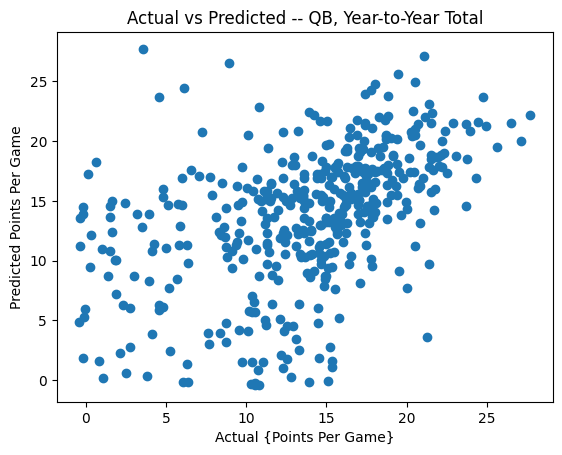

In [27]:
# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(qb_y[:(len(qb_y)-1):],
                                            qb_y[1::])[0][1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(qb_y[:(len(qb_y)-1):], qb_y[1::])

# Set axis labels
ax.set_xlabel('Actual {Points Per Game}')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- QB, Year-to-Year Total')

plt.show()

*Graph Analysis:* This shows that there is some moderate correlation in fantasy players from year to year for Quarterbacks, as we have an R-Squared of 0.48. This suggests that there is some decent foundation for making predictions off of previous values.

### *Basic Linear Regression -- QB all features*

Correlation is: 0.629689005413637


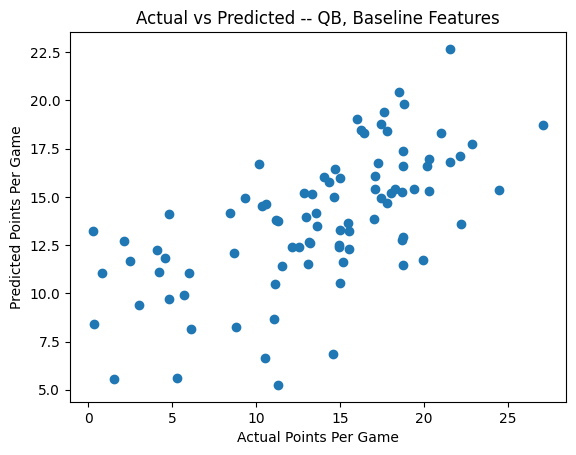

In [28]:
# Baseline features of all those that would be counted in simple linear regression
qb_baseline_features = ['passing_tds', 'passing_yards', 'interceptions', 'sacks',
                        'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards',
                        'rushing_tds', 'rushing_fumbles_lost']


# Selects the baselines features for the model
baseline_x_train = pd.DataFrame(qb_x_train)[qb_baseline_features]
baseline_x_test = pd.DataFrame(qb_x_test)[qb_baseline_features]

# Creates and fits the model
linear_reg_model = LinearRegression()
linear_reg_model.fit(baseline_x_train, qb_y_train)
qb_y_pred = linear_reg_model.predict(baseline_x_test)

# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(qb_y_test, qb_y_pred)[0][1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(qb_y_test, qb_y_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- QB, Baseline Features')

plt.show()

### Comparison to full score regression

Correlation is: 0.6273809859705902


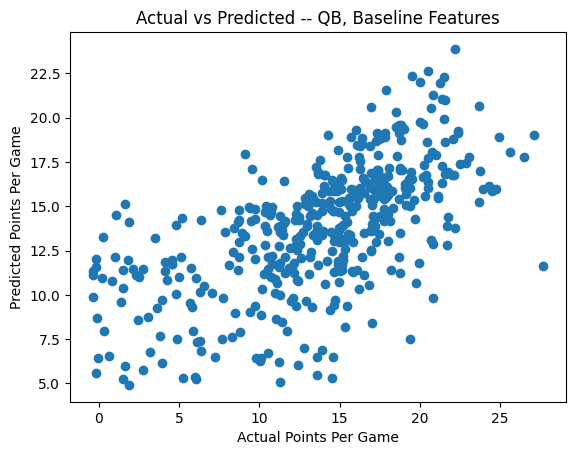

[ 3.05037233  0.02541706 -1.63365499 -0.64573025  0.5852003   0.99217002
  0.07771877  3.76593319 -3.81145104]


In [29]:
# Baseline features of all those that would be counted in simple linear regression
qb_baseline_features = ['passing_tds', 'passing_yards', 'interceptions', 'sacks',
                        'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards',
                        'rushing_tds', 'rushing_fumbles_lost']


# Selects the baselines features for the model
baseline_x = pd.DataFrame(qb_x)[qb_baseline_features]

# Creates and fits the model
linear_reg_model = LinearRegression()
linear_reg_model.fit(baseline_x, qb_y)
qb_y_pred = linear_reg_model.predict(baseline_x)

# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(qb_y, qb_y_pred)[0][1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(qb_y, qb_y_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- QB, Baseline Features')

plt.show()

print (linear_reg_model.coef_)

*Graph Analysis:* The correlation factor jumps substantially when accounting for individual values! This could be due to the inherent randomness with some high value categories, like touchdowns, but suggests that the underlying data really is similar year to you.

Of course, this feature set is only comprised of the variables that go into a standard fantasy PPR score; however, there are three interesting notes.

1.   There appears to be a linear relationship between the two terms. Since these fantasy scores are simply a linear combination of the features, this suggests that linear regression is a good candidate for prediction.

2.   This solely accounts for scored statistics, nothing regarding team presence. Not as much of an impact for QBs, since they're typically starting the whole game, but worth noting.

3.   Correlation above 10 PPG seems to be much better, worth an additional experiment to see if we can restrict to those values.





### *Basic Linear Regression -- QB all features [>10 PPG]*



Correlation is: 0.556099116129888
MSE: 20.939025863362346


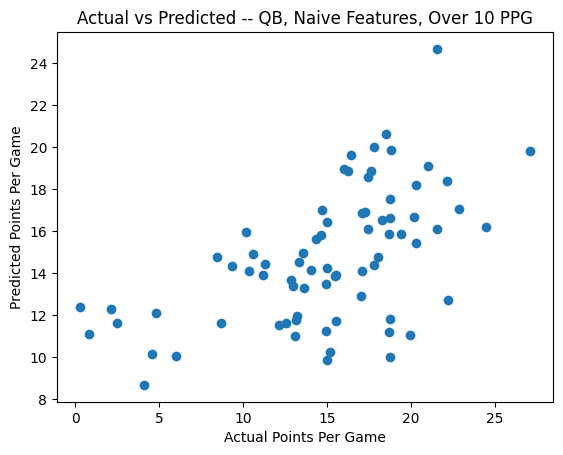

In [30]:
# Selects the baselines features for the model
qb_x_train = pd.DataFrame(qb_x_train)
qb_x_test = pd.DataFrame(qb_x_test)
baseline_x_train = qb_x_train[qb_baseline_features]
baseline_x_test = qb_x_test[qb_baseline_features]
baseline_y_train = pd.DataFrame(qb_y_train)
baseline_y_test = pd.DataFrame(qb_y_test)

# Takes the values over 10 ppg
train_mask = np.where(((qb_x_train['fantasy_points_ppr']/qb_x_train['games']) > 10), 1, 0)
test_mask  = np.where(((qb_x_test['fantasy_points_ppr']/qb_x_test['games']) > 10), 1, 0)

over_10_x_train = baseline_x_train.loc[train_mask == 1]
over_10_x_test = baseline_x_test.loc[test_mask == 1]
over_10_y_train = baseline_y_train.loc[train_mask == 1]
over_10_y_test = baseline_y_test.loc[test_mask == 1]

# Creates and fits the model
naive_model = LinearRegression()
naive_model.fit(over_10_x_train, over_10_y_train)
over_10_y_pred = naive_model.predict(over_10_x_test)
over_10_y_pred = over_10_y_pred.flatten()
over_10_y_test = (over_10_y_test.values).flatten()

# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(over_10_y_test, over_10_y_pred)[0, 1]))
print ("MSE: " + str(mean_squared_error(over_10_y_test, over_10_y_pred)))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(over_10_y_test, over_10_y_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- QB, Naive Features, Over 10 PPG')

plt.show()

*Graph Analysis:* The correlation factor appears similar to that of the unconstrained set, though slightly smalled; however, this is likely better, as the trend appears more consistent/skewed by outliers and is more reflective of the players who we're seeking to draft. Thus, restriction on fitting higher-performing players seems like a good idea.

## **Enhanced Prediction -- QBs**


### *Gets The Top Performers*

In [31]:
# Stores the x, y train and test data
x_train = pd.DataFrame(qb_x_train).loc[train_mask == 1]
x_test = pd.DataFrame(qb_x_test).loc[test_mask == 1]
y_train = (pd.DataFrame(qb_y_train).loc[train_mask == 1].values).flatten()
y_test = (pd.DataFrame(qb_y_test).loc[test_mask == 1].values).flatten()
print ("QB Examples: " + str(len(x_train)) + " Train Examples, " + str(len(x_test)) + " Test Examples")

QB Examples: 287 Train Examples, 74 Test Examples


### *Forward Selection for Parameters*

In [32]:
# Conducts forward selection
def forward_selection(x, y, predictors):

  # Initializes the best prediction value
  best_predictor = None

  # Stores the largest r-squared values
  largest_r_squared = -1

  # Loops through the predictors in our input data
  for curr_predictor in x.columns:

    # If our current predictor is not already chosen, we see evaluate its RSS
    if (curr_predictor not in predictors):
      test = predictors + [curr_predictor]
      test_model = LinearRegression()
      test_model.fit(x[test], y)
      y_pred = test_model.predict(x[test])

      # Gets the current score for the model
      curr_rsquared = np.corrcoef(y, y_pred)[0, 1]

      # If this new test model has the highest r-squared, we save it
      if (curr_rsquared > largest_r_squared):
        largest_r_squared = curr_rsquared
        best_predictor = curr_predictor

  # Returns the best predictor
  return best_predictor

In [33]:
qb_baseline_features = ['passing_tds', 'passing_yards', 'interceptions', 'sacks',
                        'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards',
                        'rushing_tds', 'rushing_fumbles_lost']

other_features = np.setdiff1d(full_qb_features, qb_baseline_features)

# Gets the relevant features for qb analysis
full_qb_x_train = x_train[full_qb_features]
full_qb_x_test = x_test[full_qb_features]

# Stores the forward feature sets for the variables
forward_feature_sets = []

# Gets the top 10 predictors for our variables
curr_predictors = qb_baseline_features
for predictor in range (0, len(other_features), 1):

  # Gets the next best predictor
  next_predictor = forward_selection(full_qb_x_train, y_train, curr_predictors)

  # Adds the predictor to our group of predictors
  if (next_predictor != None):
    curr_predictors.append(next_predictor)

  # Conducts Linear Regression
  test_model = LinearRegression()
  test_model.fit(full_qb_x_train[curr_predictors], y_train)
  y_pred = test_model.predict(full_qb_x_test[curr_predictors])

  # Outputs findings
  print (curr_predictors)
  print ("Train Correlation is: " + str(np.corrcoef(test_model.predict(full_qb_x_train[curr_predictors]), y_train)[0, 1]))
  print ("Test Correlation is: " + str(np.corrcoef(y_pred, y_test)[0, 1]))
  print ("Most Important Feature: " + next_predictor)
  print ("\n")

# Stores the forward selected features for the current predictors
forward_selection_features = curr_predictors

['passing_tds', 'passing_yards', 'interceptions', 'sacks', 'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_fumbles']
Train Correlation is: 0.6314515963936146
Test Correlation is: 0.5223187194098162
Most Important Feature: rushing_fumbles


['passing_tds', 'passing_yards', 'interceptions', 'sacks', 'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_fumbles', 'completions']
Train Correlation is: 0.6376229226424583
Test Correlation is: 0.5307131144448712
Most Important Feature: completions


['passing_tds', 'passing_yards', 'interceptions', 'sacks', 'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_fumbles', 'completions', 'passing_epa']
Train Correlation is: 0.6471745139759837
Test Correlation is: 0.5504891622122471
Most Important Feature: passing_epa


['passing_tds', 'passing_yards', 'interceptions'

## Backwards Selection

In [34]:
# Conducts forward selection
def backwards_selection(y, x, all_predictors, prev_rsquared, saved_features):

  # Initializes the worse prediction value
  new_predictors = None
  removed_predictor = None
  worst_rsquared = prev_rsquared

  # Loops through the predictors in our input data
  for curr_predictor in all_predictors:

    # Doesn't alow us to take a saved feature
    if (curr_predictor not in saved_features):

      # Gets the removed predictos
      removed_predictors = []
      for predictor in all_predictors:
        if (predictor != curr_predictor):
          removed_predictors.append(predictor)

      if (len(removed_predictors) == 0):
        return ([], curr_predictor)

      # If our current predictor is not already chosen, we see evaluate its aic
      test_model = LinearRegression()
      test_model.fit(x[removed_predictors], y)
      y_pred = test_model.predict(x[removed_predictors])

      # Gets the current score for the model
      curr_rsquared = np.corrcoef(y, y_pred)[0, 1]

      # If this new test model has the highest aic, we save it
      if (curr_rsquared < worst_rsquared):
        worst_rsquared = curr_rsquared
        new_predictors = removed_predictors
        removed_predictor = curr_predictor

  # Returns the best predictor
  return (new_predictors, removed_predictor)

In [35]:
qb_baseline_features = ['passing_tds', 'passing_yards', 'interceptions', 'sacks',
                        'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards',
                        'rushing_tds', 'rushing_fumbles_lost']

# Primes the data for the current predictors
removed_order = []
curr_predictors = full_qb_features

# Calculates the R-Squared value for the regression
test_model = LinearRegression()
test_model.fit(full_qb_x_train, y_train)
y_train_pred = test_model.predict(full_qb_x_train)
curr_rsquared = np.corrcoef(y_train, y_train_pred)[0, 1]

# Loops through the removed predictors to determine if fit works
for predictor in range (0, len(other_features), 1):

  # Updates the parameters
  new_predictors, removed = backwards_selection(y_train, x_train, curr_predictors, curr_rsquared, qb_baseline_features)
  removed_order.append(removed)
  curr_predictors = new_predictors

  # Conducts Linear Regression
  test_model = LinearRegression()
  test_model.fit(full_qb_x_train[curr_predictors], y_train)
  y_pred = test_model.predict(full_qb_x_test[curr_predictors])

  # Outputs findings
  print (curr_predictors)
  print ("Train Correlation is: " + str(np.corrcoef(test_model.predict(full_qb_x_train[curr_predictors]), y_train)[0, 1]))
  print ("Test Correlation is: " + str(np.corrcoef(y_pred, y_test)[0, 1]))
  print ("Most Important Feature: " + removed)
  print ("\n")

# Stores the forward selected features for the current predictors
backwards_selection_features = removed_order

['completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions']
Train Correlation is: 0.6490955801324927
Test Correlation is: 0.5488158208257646
Most Important Feature: rushing_fumbles


['completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions']
Train Correlation is: 0.6435147643681122
Test Correlation is: 0.5462446239690918
Most Im

## Most Important Features -- Now Defunct (Backwards and Forwards Selection Yielded Nothing)

Forward Selection Features:  ['passing_tds', 'passing_yards', 'interceptions', 'sacks', 'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_fumbles', 'completions', 'passing_epa', 'rushing_epa', 'attempts', 'rushing_2pt_conversions', 'passing_first_downs', 'pacr', 'dakota', 'passing_air_yards', 'sack_fumbles', 'carries', 'rushing_first_downs', 'passing_yards_after_catch', 'sack_yards']
Backward Selection Features:  ['rushing_fumbles', 'passing_epa', 'dakota', 'completions', 'rushing_2pt_conversions', 'attempts', 'rushing_epa', 'passing_first_downs', 'sack_yards', 'passing_air_yards', 'carries', 'sack_fumbles', 'rushing_first_downs', 'pacr', 'passing_yards_after_catch']
Best Weight: 1
Test Accuracy: 0.5534572776084749
MSE: 20.99303836054571


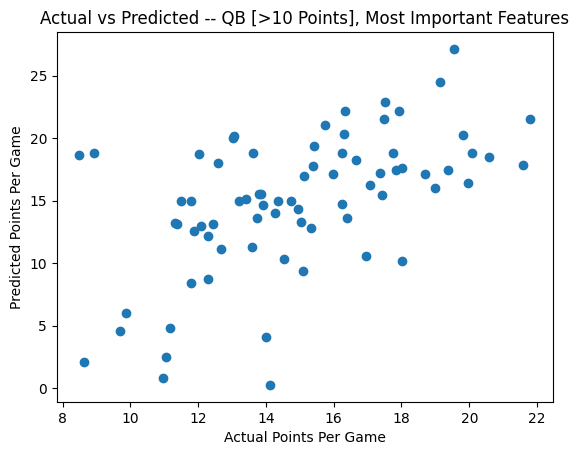

In [36]:
print ("Forward Selection Features: ", forward_selection_features)
print ("Backward Selection Features: ", backwards_selection_features)

# Stores the feature points for the full_qb_features
feature_points = dict()

# Adds points to determine best features
for val in other_features:
  forward_selection_point = (len(other_features) - forward_selection_features.index(val))
  backward_selection_point = (len(other_features) - backwards_selection_features.index(val))
  feature_points[val] = (forward_selection_point + backward_selection_point)

# Sorts the keys in the function
sorted_keys = []
for k in sorted(feature_points, key=feature_points.get)[::-1]:
    sorted_keys.append(k)

# Determines the final parameters for our model
final_parameters = sorted_keys[:10:]

# Lasso Regression
enhanced_model = LinearRegression()
enhanced_model.fit(full_qb_x_train[final_parameters], y_train)
y_pred = enhanced_model.predict(full_qb_x_test[final_parameters])

# Stores the possible_weights for the function based off of other features
weights = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
best_weight = 0
best_score = 500
for weight in weights:
  combined_pred = weight*(y_pred.flatten()) + (1-weight)*(over_10_y_pred.flatten())
  curr_score = np.corrcoef(combined_pred, y_test)[0, 1]
  if (curr_score < best_score):
    best_score = curr_score
    best_weight = weight

print ("Best Weight: " + str(best_weight))
combined_pred = best_weight*y_pred + (1-best_weight)*over_10_y_pred

print ("Test Accuracy: " + str(np.corrcoef(combined_pred, y_test)[0, 1]))
print ("MSE: " + str(mean_squared_error(combined_pred, y_test)))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(combined_pred, y_test)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- QB [>10 Points], Most Important Features')

plt.show()

Looking at this combination of forward and backwards selected feature with our baseline features, we see a slight improvement over the correlation of the baseline features and more uniform variance among the actual/predicted points per game.
Additionally, we see our metrics may be weighed down by the points at the bottom, leading to a higher accuracy for top players than suggested by the model statistics.

## QB Test Set Calculations (Mixture Model) -- Now Defunct (Forwards/Backwards Selection yielded nothing)

In [ ]:
# Creates the mixture model for the qb stat prediction
final_input = pd.DataFrame(qb_x_2022)
final_mask = np.where(((final_input['fantasy_points_ppr']/final_input['games']) > 10), 1, 0)
players_to_predict = final_input.loc[final_mask == 1]

# Makes predictions off of our top players
baseline_pred = (naive_model.predict(players_to_predict[qb_baseline_features])).flatten()
enhanced_pred = (enhanced_model.predict(players_to_predict[final_parameters])).flatten()

# Calculates the prediction based on weight
predictions = best_weight*enhanced_pred + (1-best_weight)*baseline_pred

# Gets rankings of players in our list
player_ranks = np.argsort(predictions)[::-1]
output_player_ranks(player_ranks, 2022)

1943    Jalen Hurts
Name: player_name, dtype: object
1995    Joe Burrow
Name: player_name, dtype: object
780    Patrick Mahomes
Name: player_name, dtype: object
1181    Josh Allen
Name: player_name, dtype: object
1555    Daniel Jones
Name: player_name, dtype: object
1140    Lamar Jackson
Name: player_name, dtype: object
0    Tom Brady
Name: player_name, dtype: object
1913    Justin Herbert
Name: player_name, dtype: object
192    Geno Smith
Name: player_name, dtype: object
1311    Kyler Murray
Name: player_name, dtype: object
2360    Trevor Lawrence
Name: player_name, dtype: object
586    Dak Prescott
Name: player_name, dtype: object
119    Kirk Cousins
Name: player_name, dtype: object
15    Matt Ryan
Name: player_name, dtype: object
2337    Justin Fields
Name: player_name, dtype: object
1780    Tua Tagovailoa
Name: player_name, dtype: object
1000    Mike White
Name: player_name, dtype: object
597    Jared Goff
Name: player_name, dtype: object
263    Jimmy Garoppolo
Name: player_name, d

*Analysis*: Interestingly, no mixture, nor added variable tested through forward or backwards selection suggests any improvement here. This simply makes us overfit the training data more.

Either these advanced statistics have little correlation with fantasy football statistics beyond what we've already discovered, or QBs just have a lot of noise inherent to the position.

In any case, the baseline features model appears to be our strongest. Even regularizing models like Lasso and Ridge had lower output.

## Final QB Model -- Testing (LinReg, Lasso, Ridge)

Linear Regression Correlation is: 0.556099116129888
Linear Regression MSE is: 20.939025863362346
Lasso Regression Correlation is: 0.5850162477063946
Lasso Regression MSE is: 20.145498250664012
Ridge Regression Correlation is: 0.5676761539834767
Ridge Regression MSE is: 20.572465771060216


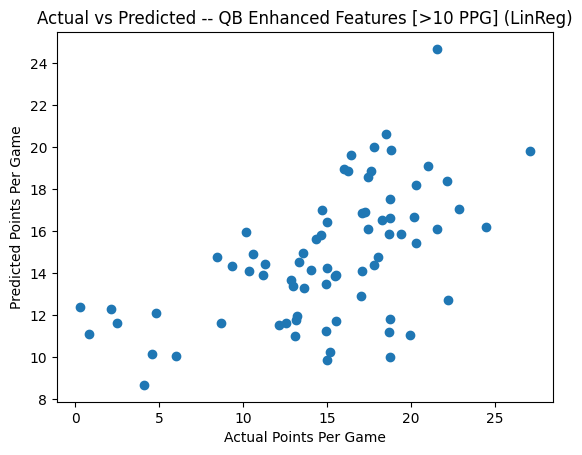

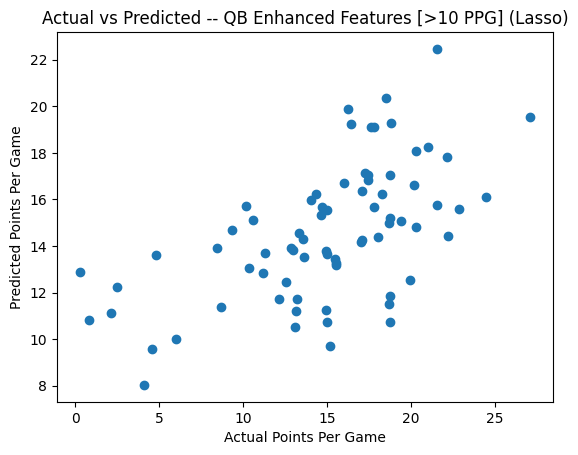

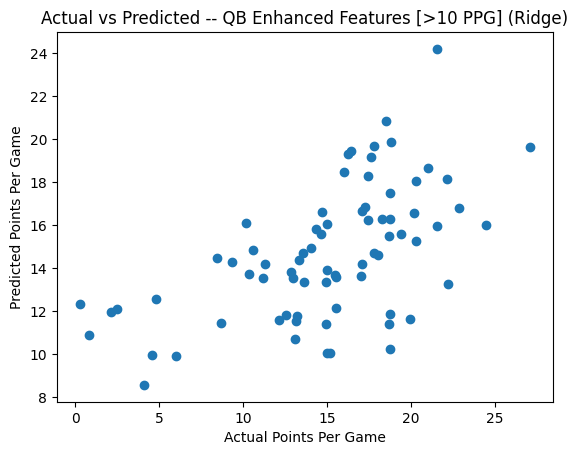

In [37]:
# Imports our models for final testing now that parameters have been selected
linear_reg_model = LinearRegression()
lasso_reg_model = LassoCV()
ridge_reg_model = RidgeCV()
#pca_reg_model =


# Gets the features used in the final model
qb_final_features = ['passing_tds', 'passing_yards', 'interceptions', 'sacks',
                        'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards',
                        'rushing_tds', 'rushing_fumbles_lost']

# Selects the baselines features for the model
final_qb_test_x_train = x_train[qb_final_features]
final_qb_test_x_test = x_test[qb_final_features]

# Linear Regression fit
linear_reg_model.fit(final_qb_test_x_train, y_train)
lin_reg_qb_pred = linear_reg_model.predict(final_qb_test_x_test)

# Lasso Regression fit
lasso_reg_model.fit(final_qb_test_x_train, y_train)
lasso_reg_qb_pred = lasso_reg_model.predict(final_qb_test_x_test)

# Ridge Regression fit
ridge_reg_model.fit(final_qb_test_x_train, y_train)
ridge_reg_qb_pred = ridge_reg_model.predict(final_qb_test_x_test)


# Calculates correlation for the models
print ("Linear Regression Correlation is: " + str(np.corrcoef(y_test, lin_reg_qb_pred)[0][1]))
print ("Linear Regression MSE is: " + str(mean_squared_error(y_test, lin_reg_qb_pred)))
print ("Lasso Regression Correlation is: " + str(np.corrcoef(y_test, lasso_reg_qb_pred)[0][1]))
print ("Lasso Regression MSE is: " + str(mean_squared_error(y_test, lasso_reg_qb_pred)))
print ("Ridge Regression Correlation is: " + str(np.corrcoef(y_test, ridge_reg_qb_pred)[0][1]))
print ("Ridge Regression MSE is: " + str(mean_squared_error(y_test, ridge_reg_qb_pred)))

# Plot actual vs predicted -- Linear Regression
fig, ax = plt.subplots()
ax.scatter(y_test, lin_reg_qb_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- QB Enhanced Features [>10 PPG] (LinReg)')

plt.show()

# Plot actual vs predicted - Lasso Regression
fig, ax = plt.subplots()
ax.scatter(y_test, lasso_reg_qb_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- QB Enhanced Features [>10 PPG] (Lasso)')

plt.show()

# Plot actual vs predicted - Ridge Regression
fig, ax = plt.subplots()
ax.scatter(y_test, ridge_reg_qb_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- QB Enhanced Features [>10 PPG] (Ridge)')

plt.show()

## Final QB Model -- Lasso Regression on Baseline Features

In [41]:
# Creates the mixture model for the qb stat prediction
final_input = pd.DataFrame(final_qb_x)
final_mask = np.where(((final_input['fantasy_points_ppr']/final_input['games']) > 10), 1, 0)
players_to_predict = final_input.loc[final_mask == 1]

# Gets the features used in the final model
qb_baseline_features = ['passing_tds', 'passing_yards', 'interceptions', 'sacks',
                        'sack_fumbles_lost', 'passing_2pt_conversions', 'rushing_yards',
                        'rushing_tds', 'rushing_fumbles_lost']


# Makes predictions off of our top players
final_qb_model = LassoCV()
final_qb_model.fit(pd.DataFrame(qb_x)[qb_baseline_features], qb_y)
predictions = final_qb_model.predict(players_to_predict[qb_baseline_features])

# Gets rankings of players in our list
player_ranks = np.argsort(predictions)[::-1]
output_player_ranks(player_ranks, 2022)

1181    Josh Allen
Name: player_name, dtype: object
780    Patrick Mahomes
Name: player_name, dtype: object
1943    Jalen Hurts
Name: player_name, dtype: object
1140    Lamar Jackson
Name: player_name, dtype: object
1995    Joe Burrow
Name: player_name, dtype: object
2337    Justin Fields
Name: player_name, dtype: object
1311    Kyler Murray
Name: player_name, dtype: object
192    Geno Smith
Name: player_name, dtype: object
1780    Tua Tagovailoa
Name: player_name, dtype: object
586    Dak Prescott
Name: player_name, dtype: object
2360    Trevor Lawrence
Name: player_name, dtype: object
1555    Daniel Jones
Name: player_name, dtype: object
1913    Justin Herbert
Name: player_name, dtype: object
597    Jared Goff
Name: player_name, dtype: object
0    Tom Brady
Name: player_name, dtype: object
119    Kirk Cousins
Name: player_name, dtype: object
1000    Mike White
Name: player_name, dtype: object
251    Derek Carr
Name: player_name, dtype: object
426    Marcus Mariota
Name: player_name, 

## Prints Top Player Names

In [40]:
# Prints top player names
def output_player_ranks(player_ranks, year):

  # Gets the seasonal roster for name output
  seasonal_roster = nfl.import_seasonal_rosters([year])

  # Outputs player name for player ranks
  for player_index in player_ranks:

      # Gets the player id
      curr_player = players_to_predict.iloc[player_index]
      player_id = curr_player['player_id']

      # Gets the player name
      player = seasonal_roster.loc[seasonal_roster['player_id'] == player_id]
      player_name = player['player_name']
      print (player_name)

## Prediction -- Running Backs

### *Simple Previous to Following Year Comparison*

Correlation is: 0.5531294425588822


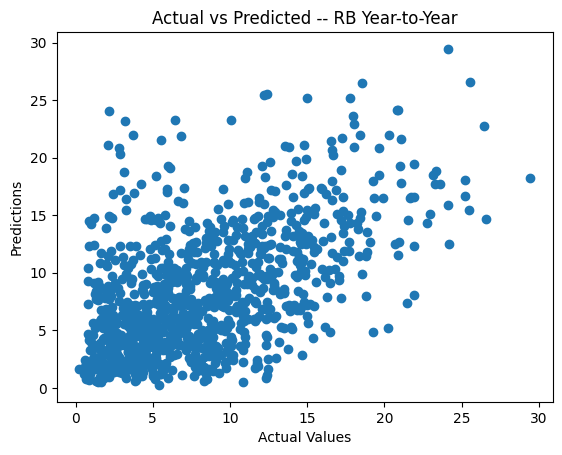

In [42]:
# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(rb_y[:(len(rb_y)-1):],
                                            rb_y[1::])[0][1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(rb_y[:(len(rb_y)-1):], rb_y[1::])

# Set axis labels
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predictions')

# Set plot title
ax.set_title('Actual vs Predicted -- RB Year-to-Year')

plt.show()

*Graph Analysis:* This shows that there is some moderate correlation in fantasy players from year to year for Running Backs, as we have an R-Squared of 0.55 -- which is slightly better than QBs. This suggests that there is some decent foundation for making predictions off of previous values.

### *Basic Linear Regression -- RB baseline features*

Correlation is: 0.6660621314384995


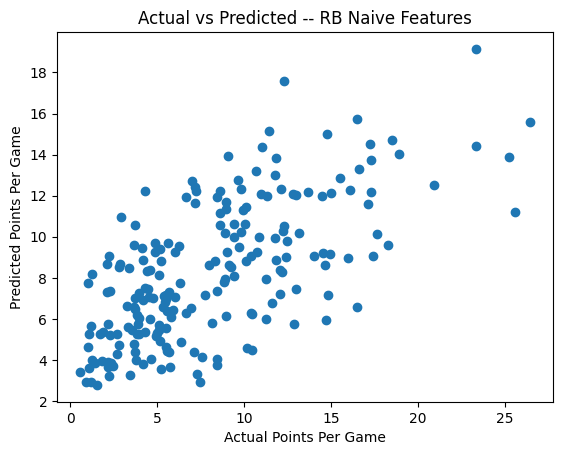

In [43]:
# Baseline features of all those that would be counted in simple linear regression
rb_baseline_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
                        'rushing_2pt_conversions', 'receptions', 'receiving_yards',
                        'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions']


# Selects the baselines features for the model
baseline_x_train = pd.DataFrame(rb_x_train)[rb_baseline_features]
baseline_x_test = pd.DataFrame(rb_x_test)[rb_baseline_features]

# Creates and fits the model
linear_reg_model = LinearRegression()
linear_reg_model.fit(baseline_x_train, rb_y_train)
rb_y_pred = linear_reg_model.predict(baseline_x_test)

# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(rb_y_test, rb_y_pred)[0][1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(rb_y_test, rb_y_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- RB Naive Features')

plt.show()

*Graph Analysis:* Similar to QBs, the correlation factor jumps substantially when accounting for individual values! This could be due to the inherent randomness with some high value categories, like touchdowns, but suggests that the underlying data really is similar year to year.

Of course, this feature set is only comprised of the variables that go into a standard fantasy PPR score; however, there are three interesting notes.

1.   There appears to be a linear relationship between the two terms. Since these fantasy scores are simply a linear combination of the features, this suggests that linear regression is a good candidate for prediction.

2.   This solely accounts for scored statistics, nothing regarding team presence. Unlike QBs, this is going to impact lower-value RBs a lot more, as fantasy output is highly correlated with opportunity for RBs.

3.   There seems to be a lot of variance among the top players. It might be tougher to align top performers than with QBs, so we'll have to look more at performance metrics


## *Gets the Top Performers*

In [44]:
# Gets the rb train and test mask -- takes the values over 8 ppg
rb_x_train = pd.DataFrame(rb_x_train)
rb_y_train = pd.DataFrame(rb_y_train)
rb_x_test = pd.DataFrame(rb_x_test)
rb_y_test = pd.DataFrame(rb_y_test)
train_mask = np.where(((rb_x_train['fantasy_points_ppr']/rb_x_train['games']) > 8), 1, 0)
test_mask  = np.where(((rb_x_test['fantasy_points_ppr']/rb_x_test['games']) > 8), 1, 0)

# Stores the x, y train and test data
x_train = rb_x_train.loc[train_mask == 1]
x_test = rb_x_test.loc[test_mask == 1]
y_train = (rb_y_train.loc[train_mask == 1].values).flatten()
y_test = (rb_y_test.loc[test_mask == 1].values).flatten()
print ("RB Examples: " + str(len(x_train)) + " Train Examples, " + str(len(x_test)) + " Test Examples")

RB Examples: 397 Train Examples, 101 Test Examples


### *Basic Linear Regression -- RB baseline features*

Correlation is: 0.5048255831995574


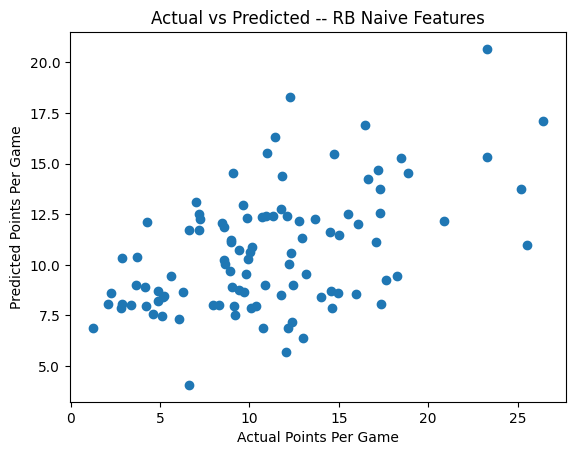

In [45]:
# Baseline features of all those that would be counted in simple linear regression
rb_baseline_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
                        'rushing_2pt_conversions', 'receptions', 'receiving_yards',
                        'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions']


# Selects the baselines features for the model
baseline_x_train = x_train[rb_baseline_features]
baseline_x_test = x_test[rb_baseline_features]

# Creates and fits the model
linear_reg_model = LinearRegression()
linear_reg_model.fit(baseline_x_train, y_train)
rb_y_pred_over_8 = linear_reg_model.predict(baseline_x_test)

# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(y_test, rb_y_pred_over_8)[0][1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(y_test, rb_y_pred_over_8)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- RB Naive Features')

plt.show()

## *Enhanced Model*

### **Forward Selection**

In [46]:
full_rb_features = ['carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
                    'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
                    'rushing_2pt_conversions', 'receptions', 'targets',
                    'receiving_yards', 'receiving_tds', 'receiving_fumbles',
                    'receiving_fumbles_lost', 'receiving_air_yards',
                    'receiving_yards_after_catch', 'receiving_first_downs',
                    'receiving_epa', 'receiving_2pt_conversions', 'racr',
                    'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh',
                    'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh',
                    'rtdfd_sh', 'yptmpa']

# Baseline features of all those that would be counted in simple linear regression
rb_baseline_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
                        'rushing_2pt_conversions', 'receptions', 'receiving_yards',
                        'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions']

other_features = np.setdiff1d(full_rb_features, rb_baseline_features)

# Gets the relevant features for qb analysis
full_rb_x_train = x_train[full_rb_features]
full_rb_x_test = x_test[full_rb_features]

# Stores the forward feature sets for the variables
forward_feature_sets = []

# Gets the top 10 predictors for our variables
curr_predictors = rb_baseline_features
for predictor in range (0, len(other_features), 1):

  # Gets the next best predictor
  next_predictor = forward_selection(full_rb_x_train, y_train, curr_predictors)

  # Adds the predictor to our group of predictors
  if (next_predictor != None):
    curr_predictors.append(next_predictor)

  # Conducts Linear Regression
  test_model = LinearRegression()
  test_model.fit(full_rb_x_train[curr_predictors], y_train)
  y_pred = test_model.predict(full_rb_x_test[curr_predictors])

  # Outputs findings
  print (curr_predictors)
  print ("Train Correlation is: " + str(np.corrcoef(test_model.predict(full_rb_x_train[curr_predictors]), y_train)[0, 1]))
  print ("Test Correlation is: " + str(np.corrcoef(y_pred, y_test)[0, 1]))
  print ("Most Important Feature: " + next_predictor)
  print ("\n")

# Stores the forward selected features for the current predictors
forward_selection_features = curr_predictors

['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_2pt_conversions', 'receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'ry_sh']
Train Correlation is: 0.6589669890306181
Test Correlation is: 0.5023295427491372
Most Important Feature: ry_sh


['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_2pt_conversions', 'receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'ry_sh', 'rushing_epa']
Train Correlation is: 0.6630593084973303
Test Correlation is: 0.5134061237427423
Most Important Feature: rushing_epa


['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_2pt_conversions', 'receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'ry_sh', 'rushing_epa', 'yac_sh']
Train Correlation is: 0.6657365509705846
Test Correlation is: 0.5043791390471726
Most Important Feature: yac_sh


['rushing_yards', 'r

Most important features appear to be: ry_sh, rushing_epa

### **Backwards Selection**

In [47]:
# Baseline features of all those that would be counted in simple linear regression
rb_baseline_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
                        'rushing_2pt_conversions', 'receptions', 'receiving_yards',
                        'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions']

# Primes the data for the current predictors
removed_order = []
curr_predictors = full_rb_features

# Calculates the R-Squared value for the regression
test_model = LinearRegression()
test_model.fit(full_rb_x_train, y_train)
y_train_pred = test_model.predict(full_rb_x_train)
curr_rsquared = np.corrcoef(y_train, y_train_pred)[0, 1]

# Loops through the removed predictors to determine if fit works
for predictor in range (0, len(other_features), 1):

  # Updates the parameters
  new_predictors, removed = backwards_selection(y_train, x_train, curr_predictors, curr_rsquared, rb_baseline_features)
  removed_order.append(removed)
  curr_predictors = new_predictors

  # Conducts Linear Regression
  test_model = LinearRegression()
  test_model.fit(full_rb_x_train[curr_predictors], y_train)
  y_pred = test_model.predict(full_rb_x_test[curr_predictors])

  # Outputs findings
  print (curr_predictors)
  print ("Train Correlation is: " + str(np.corrcoef(test_model.predict(full_rb_x_train[curr_predictors]), y_train)[0, 1]))
  print ("Test Correlation is: " + str(np.corrcoef(y_pred, y_test)[0, 1]))
  print ("Most Important Feature: " + removed)
  print ("\n")

# Stores the forward selected features for the current predictors
backwards_selection_features = removed_order

['carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'rtd_sh', 'rfd_sh', 'rtdfd_sh', 'yptmpa']
Train Correlation is: 0.6744492207760402
Test Correlation is: 0.5211584308516615
Most Important Feature: ry_sh


['carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'racr'

No important features obvious from backwards selection.

Target_share, targets, and carries also added due to clear impact on reception and rushing opportunities.

## *Final Model Test*

Linear Regression Correlation is: 0.5210843015324033
Linear Regression MSE is: 21.674980648600084
Lasso Regression Correlation is: 0.5043089461842905
Lasso Regression MSE is: 21.957309765298405
Ridge Regression Correlation is: 0.5076287034906597
Ridge Regression MSE is: 21.87278681105378


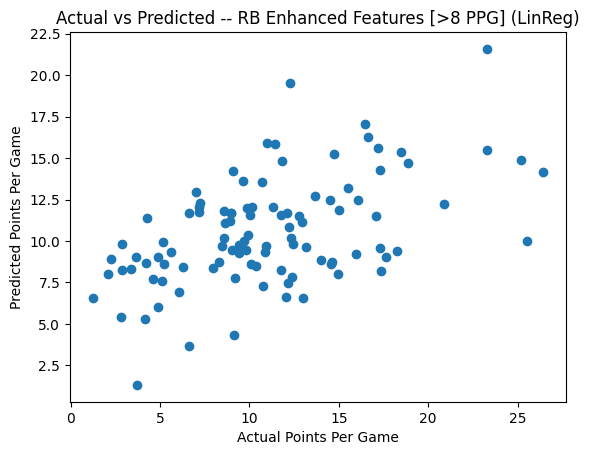

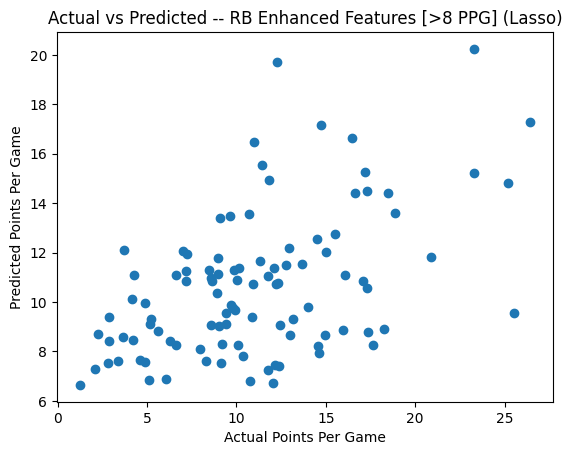

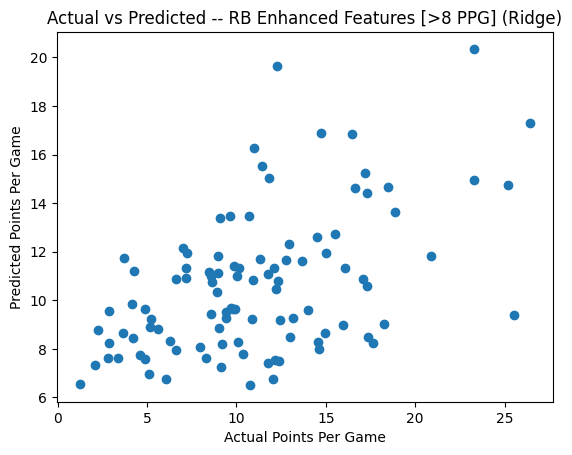

In [48]:
# Gets the features used in the final model
rb_final_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
                        'rushing_2pt_conversions', 'receptions', 'receiving_yards',
                        'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions',
                        'rushing_epa', 'targets', 'carries', 'ry_sh', 'target_share']


# Imports our models for final testing now that parameters have been selected
linear_reg_model = LinearRegression()
lasso_reg_model = LassoCV()
ridge_reg_model = RidgeCV()

# Selects the baselines features for the model
final_rb_test_x_train = x_train[rb_final_features]
final_rb_test_x_test = x_test[rb_final_features]

# Linear Regression fit
linear_reg_model.fit(final_rb_test_x_train, y_train)
lin_reg_rb_pred = linear_reg_model.predict(final_rb_test_x_test)

# Lasso Regression fit
lasso_reg_model.fit(final_rb_test_x_train, y_train)
lasso_reg_rb_pred = lasso_reg_model.predict(final_rb_test_x_test)

# Ridge Regression fit
ridge_reg_model.fit(final_rb_test_x_train, y_train)
ridge_reg_rb_pred = ridge_reg_model.predict(final_rb_test_x_test)


# Calculates correlation for the models
print ("Linear Regression Correlation is: " + str(np.corrcoef(y_test, lin_reg_rb_pred)[0][1]))
print ("Linear Regression MSE is: " + str(mean_squared_error(y_test, lin_reg_rb_pred)))
print ("Lasso Regression Correlation is: " + str(np.corrcoef(y_test, lasso_reg_rb_pred)[0][1]))
print ("Lasso Regression MSE is: " + str(mean_squared_error(y_test, lasso_reg_rb_pred)))
print ("Ridge Regression Correlation is: " + str(np.corrcoef(y_test, ridge_reg_rb_pred)[0][1]))
print ("Ridge Regression MSE is: " + str(mean_squared_error(y_test, ridge_reg_rb_pred)))

# Plot actual vs predicted -- Linear Regression
fig, ax = plt.subplots()
ax.scatter(y_test, lin_reg_rb_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- RB Enhanced Features [>8 PPG] (LinReg)')

plt.show()

# Plot actual vs predicted - Lasso Regression
fig, ax = plt.subplots()
ax.scatter(y_test, lasso_reg_rb_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- RB Enhanced Features [>8 PPG] (Lasso)')

plt.show()

# Plot actual vs predicted - Ridge Regression
fig, ax = plt.subplots()
ax.scatter(y_test, ridge_reg_rb_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- RB Enhanced Features [>8 PPG] (Ridge)')

plt.show()

Similar performance to baseline features, but we see a slight tightening and more linear trend for our model, indicating that it might have slightly more consistent performance.

## *RB Final Model* -- Linear Regression on Baseline Features plus five features selected from forwards and backwards selection: targets, carries, ry_sh, target_share, rushing_epa

In [ ]:
# Creates the mixture model for the qb stat prediction
final_input = pd.DataFrame(final_rb_x)
final_mask = np.where(((final_input['fantasy_points_ppr']/final_input['games']) > 8), 1, 0)
players_to_predict = final_input.loc[final_mask == 1]

# Gets the features used in the final model
rb_final_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
                        'rushing_2pt_conversions', 'receptions', 'receiving_yards',
                        'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions',
                        'rushing_epa', 'targets', 'carries', 'ry_sh', 'target_share']

# Makes predictions off of our top players
final_rb_model = LinearRegression()
final_rb_model.fit(pd.DataFrame(rb_x)[rb_final_features], rb_y)
predictions = final_rb_model.predict(players_to_predict[rb_final_features])

# Gets rankings of players in our list
player_ranks = np.argsort(predictions)[::-1]
output_player_ranks(player_ranks, 2022)

630    Christian McCaffrey
Name: player_name, dtype: object
740    Austin Ekeler
Name: player_name, dtype: object
1548    Josh Jacobs
Name: player_name, dtype: object
509    Derrick Henry
Name: player_name, dtype: object
1173    Saquon Barkley
Name: player_name, dtype: object
1137    Nick Chubb
Name: player_name, dtype: object
2270    Rhamondre Stevenson
Name: player_name, dtype: object
802    Joe Mixon
Name: player_name, dtype: object
1790    Jonathan Taylor
Name: player_name, dtype: object
1341    Tony Pollard
Name: player_name, dtype: object
798    Dalvin Cook
Name: player_name, dtype: object
708    James Conner
Name: player_name, dtype: object
809    Alvin Kamara
Name: player_name, dtype: object
639    Aaron Jones
Name: player_name, dtype: object
2362    Travis Etienne
Name: player_name, dtype: object
2615    Dameon Pierce
Name: player_name, dtype: object
768    Leonard Fournette
Name: player_name, dtype: object
3121    Kenneth Walker
Name: player_name, dtype: object
1325    Miles 

## Prediction -- Wide Receivers

### *Simple Previous to Following Year Comparison*


Correlation is: 0.5590359884588936


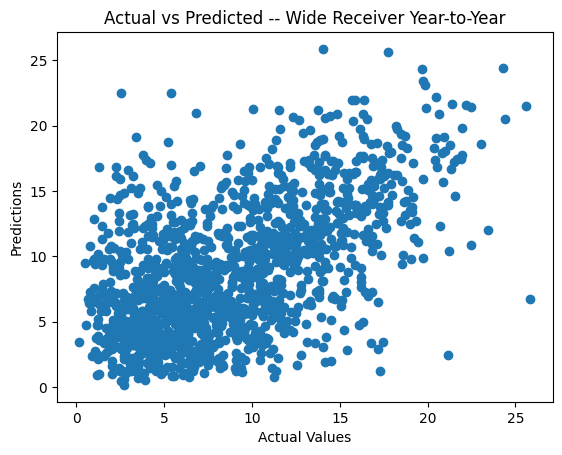

In [49]:
# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(wr_y[:(len(wr_y)-1):],
                                            wr_y[1::])[0][1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(wr_y[:(len(wr_y)-1):], wr_y[1::])

# Set axis labels
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predictions')

# Set plot title
ax.set_title('Actual vs Predicted -- Wide Receiver Year-to-Year')

plt.show()

*Graph Analysis:* This shows that there is some moderate correlation in fantasy players from year to year for Wide Receivers, as we have an R-Squared of 0.56 -- which is slightly better than QBs and about the same as RBs. This suggests that there is some decent foundation for making predictions off of previous values.

### *Basic Linear Regression -- WR all features*

Correlation is: 0.6739898773959191


Text(0.5, 1.0, 'Actual vs Predicted -- Wide Receiver, Naive Features')

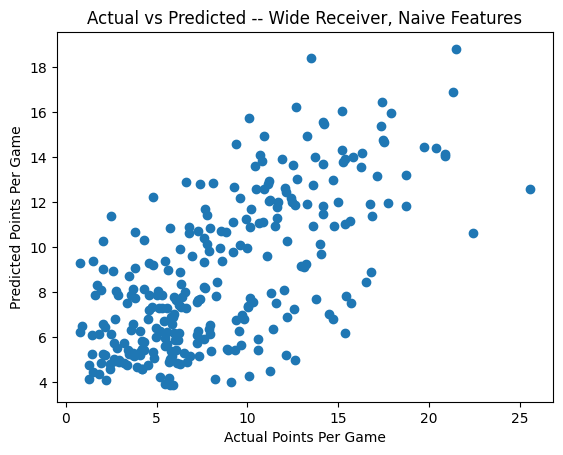

In [50]:
# Baseline features of all those that would be counted in simple linear regression
wr_baseline_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
                        'rushing_2pt_conversions', 'receptions', 'receiving_yards',
                        'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions']


# Selects the baselines features for the model
baseline_x_train = pd.DataFrame(wr_x_train)[wr_baseline_features]
baseline_x_test = pd.DataFrame(wr_x_test)[wr_baseline_features]

# Creates and fits the model
linear_reg_model = LinearRegression()
linear_reg_model.fit(baseline_x_train, wr_y_train)
wr_y_pred = linear_reg_model.predict(baseline_x_test)

# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(wr_y_test, wr_y_pred)[0][1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(wr_y_test, wr_y_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- Wide Receiver, Naive Features')

*Graph Analysis:* Similar to QBs and RBs, the correlation factor jumps substantially when accounting for individual values, but substantially less so. This could be due to the inherent randomness with some high value categories, like touchdowns, but suggests that the underlying data really is similar year to year. Splitting up among individidual statistics, however, is less likely to be variable -- probably due to how WR volume is more sporadic than RB an QB volume.

Of course, this feature set is only comprised of the variables that go into a standard fantasy PPR score; however, there are three interesting notes.

1.   There appears to be a linear relationship between the two terms. Since these fantasy scores are simply a linear combination of the features, this suggests that linear regression is a good candidate for prediction.

2.   This solely accounts for scored statistics, nothing regarding team presence. Similar to RBs, this is going to impact lower-value WRs a lot more, as fantasy output is highly correlated with opportunity for WRs. Additionally, the randomness of WR volume may make it an interesting beast to tackle.

3.   There seems to be less variance among the top players than RBs. This is probably due to the fact that they have consistent volume, whereas lower-end wide receivers have less volume, but more scoring opportunity than RBs.


## *Enhanced Prediction -- Wide Receiver*

In [51]:
# Gets the wr train and test mask -- takes the values over 8 ppg
wr_x_train = pd.DataFrame(wr_x_train)
wr_y_train = pd.DataFrame(wr_y_train)
wr_x_test = pd.DataFrame(wr_x_test)
wr_y_test = pd.DataFrame(wr_y_test)
train_mask = np.where(((wr_x_train['fantasy_points_ppr']/wr_x_train['games']) > 8), 1, 0)
test_mask  = np.where(((wr_x_test['fantasy_points_ppr']/wr_x_test['games']) > 8), 1, 0)

# Stores the x, y train and test data
x_train = wr_x_train.loc[train_mask == 1]
x_test = wr_x_test.loc[test_mask == 1]
y_train = (wr_y_train.loc[train_mask == 1].values).flatten()
y_test = (wr_y_test.loc[test_mask == 1].values).flatten()
print ("WR Examples: " + str(len(x_train)) + " Train Examples, " + str(len(x_test)) + " Test Examples")

WR Examples: 609 Train Examples, 140 Test Examples


### **Forward Selection**

In [52]:
full_wr_features = ['carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
                    'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
                    'rushing_2pt_conversions', 'receptions', 'targets',
                    'receiving_yards', 'receiving_tds', 'receiving_fumbles',
                    'receiving_fumbles_lost', 'receiving_air_yards',
                    'receiving_yards_after_catch', 'receiving_first_downs',
                    'receiving_epa', 'receiving_2pt_conversions', 'racr',
                    'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh',
                    'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh',
                    'rtdfd_sh', 'yptmpa']

# Baseline features of all those that would be counted in simple linear regression
wr_baseline_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
                        'rushing_2pt_conversions', 'receptions', 'receiving_yards',
                        'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions']

other_features = np.setdiff1d(full_wr_features, wr_baseline_features)

# Gets the relevant features for qb analysis
full_wr_x_train = x_train[full_wr_features]
full_wr_x_test = x_test[full_wr_features]

# Stores the forward feature sets for the variables
forward_feature_sets = []

# Gets the top 10 predictors for our variables
curr_predictors = wr_baseline_features
for predictor in range (0, len(other_features), 1):

  # Gets the next best predictor
  next_predictor = forward_selection(full_wr_x_train, y_train, curr_predictors)

  # Adds the predictor to our group of predictors
  if (next_predictor != None):
    curr_predictors.append(next_predictor)

  # Conducts Linear Regression
  test_model = LinearRegression()
  test_model.fit(full_wr_x_train[curr_predictors], y_train)
  y_pred = test_model.predict(full_wr_x_test[curr_predictors])

  # Outputs findings
  print (curr_predictors)
  print ("Train Correlation is: " + str(np.corrcoef(test_model.predict(full_wr_x_train[curr_predictors]), y_train)[0, 1]))
  print ("Test Correlation is: " + str(np.corrcoef(y_pred, y_test)[0, 1]))
  print ("Most Important Feature: " + next_predictor)
  print ("\n")

# Stores the forward selected features for the current predictors
forward_selection_features = curr_predictors

['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_2pt_conversions', 'receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'yptmpa']
Train Correlation is: 0.6304346216049967
Test Correlation is: 0.55299401204546
Most Important Feature: yptmpa


['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_2pt_conversions', 'receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'yptmpa', 'receiving_yards_after_catch']
Train Correlation is: 0.6350617209698224
Test Correlation is: 0.5481864163156527
Most Important Feature: receiving_yards_after_catch


['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'rushing_2pt_conversions', 'receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'yptmpa', 'receiving_yards_after_catch', 'ay_sh']
Train Correlation is: 0.6410523235978446
Test Correlation is: 0.5483737609278847
Most

The most important features here appear to be the following:

1. wopr_y -- target share/team air yards
2. rushing_epa -- evasiveness valued in WR

This is intersting as this really suggests volume is king with receivers, which is consistent with conventional wisdom surrounding receivers. Much less volume dependent then RBs it seems.

### **Backward Selection**

In [ ]:
# Baseline features of all those that would be counted in simple linear regression
wr_baseline_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
                        'rushing_2pt_conversions', 'receptions', 'receiving_yards',
                        'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions']

# Primes the data for the current predictors
removed_order = []
curr_predictors = full_wr_features

# Calculates the R-Squared value for the regression
test_model = LinearRegression()
test_model.fit(full_wr_x_train, y_train)
y_train_pred = test_model.predict(full_wr_x_train)
curr_rsquared = np.corrcoef(y_train, y_train_pred)[0, 1]

# Loops through the removed predictors to determine if fit works
for predictor in range (0, len(other_features), 1):

  # Updates the parameters
  new_predictors, removed = backwards_selection(y_train, x_train, curr_predictors, curr_rsquared, wr_baseline_features)
  removed_order.append(removed)
  curr_predictors = new_predictors

  # Conducts Linear Regression
  test_model = LinearRegression()
  test_model.fit(full_wr_x_train[curr_predictors], y_train)
  y_pred = test_model.predict(full_wr_x_test[curr_predictors])

  # Outputs findings
  print (curr_predictors)
  print ("Train Correlation is: " + str(np.corrcoef(test_model.predict(full_wr_x_train[curr_predictors]), y_train)[0, 1]))
  print ("Test Correlation is: " + str(np.corrcoef(y_pred, y_test)[0, 1]))
  print ("Most Important Feature: " + removed)
  print ("\n")

# Stores the forward selected features for the current predictors
backwards_selection_features = removed_order

['carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh', 'rtdfd_sh', 'yptmpa']
Train Correlation is: 0.6706466412531301
Test Correlation is: 0.5336648921573401
Most Important Feature: targets


['carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'racr', 'target_s

The most important features here appear to be the following:

1. targets -- suggesting that targets are highly correlated with strong WR performance

## **Wide Receiver Final Model Test**

Linear Regression Correlation is: 0.6317567689881332
Linear Regression MSE is: 8.156206445184203
Lasso Regression Correlation is: 0.678329883201465
Lasso Regression MSE is: 7.60957590471954
Ridge Regression Correlation is: 0.6700438696324408
Ridge Regression MSE is: 7.484597361684595


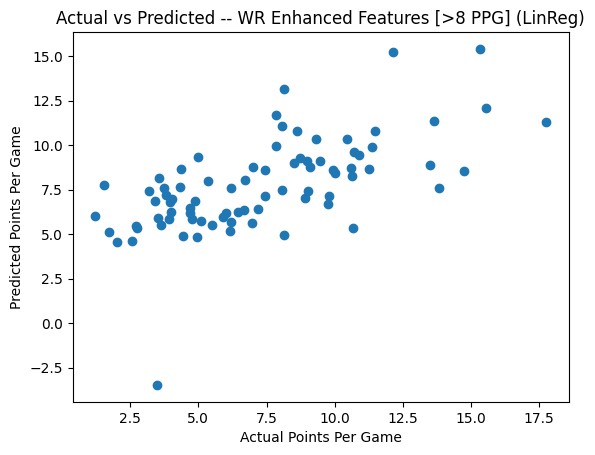

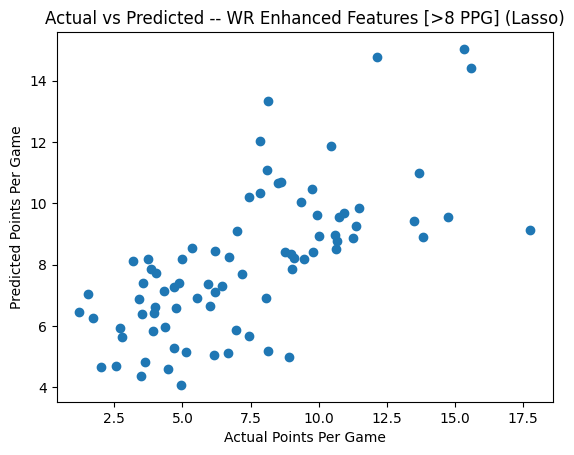

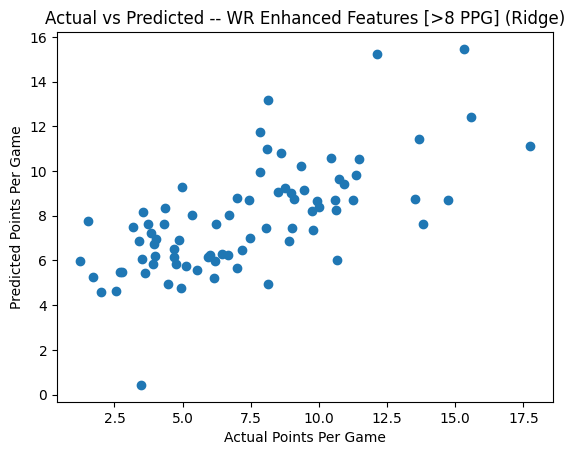

In [59]:
# Gets the features used in the final model
wr_final_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
                        'rushing_2pt_conversions', 'receptions', 'receiving_yards',
                        'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions',
                        'targets', 'wopr_y', 'rushing_epa']

# Imports our models for final testing now that parameters have been selected
linear_reg_model = LinearRegression()
lasso_reg_model = LassoCV()
ridge_reg_model = RidgeCV()

# Selects the baselines features for the model
final_wr_test_x_train = x_train[wr_final_features]
final_wr_test_x_test = x_test[wr_final_features]

# Linear Regression fit
linear_reg_model.fit(final_wr_test_x_train, y_train)
lin_reg_wr_pred = linear_reg_model.predict(final_wr_test_x_test)

# Lasso Regression fit
lasso_reg_model.fit(final_wr_test_x_train, y_train)
lasso_reg_wr_pred = lasso_reg_model.predict(final_wr_test_x_test)

# Ridge Regression fit
ridge_reg_model.fit(final_wr_test_x_train, y_train)
ridge_reg_wr_pred = ridge_reg_model.predict(final_wr_test_x_test)


# Calculates correlation for the models
print ("Linear Regression Correlation is: " + str(np.corrcoef(y_test, lin_reg_wr_pred)[0][1]))
print ("Linear Regression MSE is: " + str(mean_squared_error(y_test, lin_reg_wr_pred)))
print ("Lasso Regression Correlation is: " + str(np.corrcoef(y_test, lasso_reg_wr_pred)[0][1]))
print ("Lasso Regression MSE is: " + str(mean_squared_error(y_test, lasso_reg_wr_pred)))
print ("Ridge Regression Correlation is: " + str(np.corrcoef(y_test, ridge_reg_wr_pred)[0][1]))
print ("Ridge Regression MSE is: " + str(mean_squared_error(y_test, ridge_reg_wr_pred)))

# Plot actual vs predicted -- Linear Regression
fig, ax = plt.subplots()
ax.scatter(y_test, lin_reg_wr_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- WR Enhanced Features [>8 PPG] (LinReg)')

plt.show()

# Plot actual vs predicted - Lasso Regression
fig, ax = plt.subplots()
ax.scatter(y_test, lasso_reg_wr_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- WR Enhanced Features [>8 PPG] (Lasso)')

plt.show()

# Plot actual vs predicted - Ridge Regression
fig, ax = plt.subplots()
ax.scatter(y_test, ridge_reg_wr_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- WR Enhanced Features [>8 PPG] (Ridge)')

plt.show()

Given similarity between Linear Regression and Ridge Regression, we will take Ridge Regression here as its less likely to overfit future data.

## **WR Final Model -- Ridge Regression of Baseline Featurss + 'targets', 'wopr_y', and 'rushing_epa'**

In [60]:
# Creates the mixture model for the qb stat prediction
final_input = pd.DataFrame(final_wr_x)
final_mask = np.where(((final_input['fantasy_points_ppr']/final_input['games']) > 8), 1, 0)
players_to_predict = final_input.loc[final_mask == 1]

# Gets the features used in the final model
wr_final_features = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
                        'rushing_2pt_conversions', 'receptions', 'receiving_yards',
                        'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions',
                        'targets', 'wopr_y', 'rushing_epa']

# Makes predictions off of our top players
final_wr_model = RidgeCV()
final_wr_model.fit(pd.DataFrame(wr_x)[wr_final_features], wr_y)
predictions = final_wr_model.predict(players_to_predict[wr_final_features])

# Gets rankings of players in our list
player_ranks = np.argsort(predictions)[::-1]
output_player_ranks(player_ranks, 2022)

1883    Justin Jefferson
Name: player_name, dtype: object
570    Tyreek Hill
Name: player_name, dtype: object
277    Davante Adams
Name: player_name, dtype: object
1527    A.J. Brown
Name: player_name, dtype: object
321    Stefon Diggs
Name: player_name, dtype: object
1915    CeeDee Lamb
Name: player_name, dtype: object
2096    Jaylen Waddle
Name: player_name, dtype: object
2305    DeVonta Smith
Name: player_name, dtype: object
2353    Amon-Ra St. Brown
Name: player_name, dtype: object
1513    Terry McLaurin
Name: player_name, dtype: object
300    Amari Cooper
Name: player_name, dtype: object
3004    Garrett Wilson
Name: player_name, dtype: object
1126    Christian Kirk
Name: player_name, dtype: object
285    Mike Evans
Name: player_name, dtype: object
820    Chris Godwin
Name: player_name, dtype: object
1498    DK Metcalf
Name: player_name, dtype: object
2294    Ja'Marr Chase
Name: player_name, dtype: object
410    Tyler Lockett
Name: player_name, dtype: object
2596    Chris Olave
Nam

Interestingly, Linear Regression and Ridge Regression have same top 15 players!

## Prediction -- Tight Ends

### *Simple Previous to Following Year Comparison*


Correlation is: 0.5457883085210468


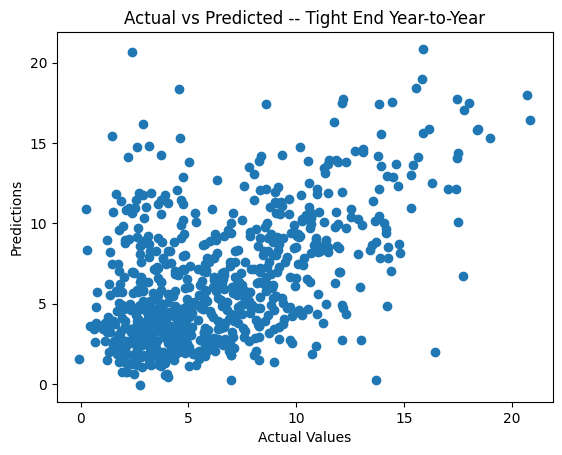

In [54]:
# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(te_y[:(len(te_y)-1):],
                                            te_y[1::])[0][1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(te_y[:(len(te_y)-1):], te_y[1::])

# Set axis labels
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predictions')

# Set plot title
ax.set_title('Actual vs Predicted -- Tight End Year-to-Year')

plt.show()

### *Basic Linear Regression -- TE all features*

Correlation is: 0.6828222953329384


Text(0.5, 1.0, 'Actual vs Predicted -- Tight End, Naive Features')

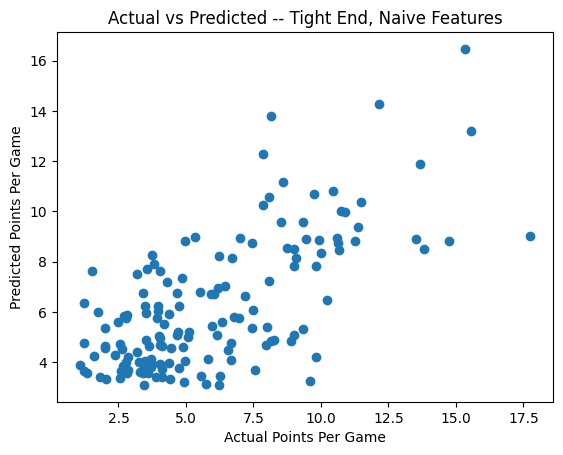

In [55]:
# Baseline features of all those that would be counted in simple linear regression
te_baseline_features = ['receptions', 'receiving_yards', 'receiving_tds',
                        'receiving_fumbles_lost', 'receiving_2pt_conversions']

# Selects the baselines features for the model
baseline_x_train = pd.DataFrame(te_x_train)[te_baseline_features]
baseline_x_test = pd.DataFrame(te_x_test)[te_baseline_features]

# Creates and fits the model
linear_reg_model = LinearRegression()
linear_reg_model.fit(baseline_x_train, te_y_train)
te_y_pred = linear_reg_model.predict(baseline_x_test)

# Calculates correlation for the model
print ("Correlation is: " + str(np.corrcoef(te_y_test, te_y_pred)[0][1]))

# Plot actual vs predicted
fig, ax = plt.subplots()
ax.scatter(te_y_test, te_y_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- Tight End, Naive Features')

*Graph Analysis:* Similar to QBs, WRs, and RBs, correlation jumps when considering individual facots This could be due to the inherent randomness with some high value categories, like touchdowns, but suggests that the underlying data really is similar year to year. Patterns seems to follow those of WRs, which makes sense since TE is largely a receiving position.

Of course, this feature set is only comprised of the variables that go into a standard fantasy PPR score; however, there are three interesting notes.

1.   There appears to be a linear relationship between the two terms. Since these fantasy scores are simply a linear combination of the features, this suggests that linear regression is a good candidate for prediction.

2.   This solely accounts for scored statistics, nothing regarding team presence. Similar to RBs and WRs, this is going to impact lower-value TEs a lot more, as fantasy output is highly correlated with opportunity for TEs. Additionally, the randomness of TE volume may make it an interesting beast to tackle.

3.   The graph seems somewhat concave, meaning that at the top level, TEs are being consistently undervalued. This could suggest that we need a points per game threshold like we do for QB.

## *Enhanced Prediction -- Tight End*

### **Takes TEs with 5 ppg or more**

In [56]:
# Gets the te train and test mask -- takes the values over 5 ppg
te_x_train = pd.DataFrame(te_x_train)
te_y_train = pd.DataFrame(te_y_train)
te_x_test = pd.DataFrame(te_x_test)
te_y_test = pd.DataFrame(te_y_test)
train_mask = np.where(((te_x_train['fantasy_points_ppr']/te_x_train['games']) > 5), 1, 0)
test_mask  = np.where(((te_x_test['fantasy_points_ppr']/te_x_test['games']) > 5), 1, 0)

# Stores the x, y train and test data
x_train = te_x_train.loc[train_mask == 1]
x_test = te_x_test.loc[test_mask == 1]
y_train = (te_y_train.loc[train_mask == 1].values).flatten()
y_test = (te_y_test.loc[test_mask == 1].values).flatten()
print ("TE Examples: " + str(len(x_train)) + " Train Examples, " + str(len(x_test)) + " Test Examples")

TE Examples: 324 Train Examples, 80 Test Examples


### **Forward Selection**

In [57]:
full_te_features = ['receptions', 'targets', 'receiving_yards', 'receiving_tds',
                    'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
                    'receiving_yards_after_catch', 'receiving_first_downs',
                    'receiving_epa', 'receiving_2pt_conversions', 'racr',
                    'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh',
                    'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh',
                    'rtdfd_sh', 'yptmpa']

# Baseline features of all those that would be counted in simple linear regression
te_baseline_features = ['receptions', 'receiving_yards', 'receiving_tds',
                        'receiving_fumbles_lost', 'receiving_2pt_conversions']

other_features = np.setdiff1d(full_te_features, te_baseline_features)

# Gets the relevant features for te analysis
full_te_x_train = x_train[full_te_features]
full_te_x_test = x_test[full_te_features]

# Stores the forward feature sets for the variables
forward_feature_sets = []

# Gets the top 10 predictors for our variables
curr_predictors = te_baseline_features
for predictor in range (0, len(other_features), 1):

  # Gets the next best predictor
  next_predictor = forward_selection(full_te_x_train, y_train, curr_predictors)

  # Adds the predictor to our group of predictors
  if (next_predictor != None):
    curr_predictors.append(next_predictor)

  # Conducts Linear Regression
  test_model = LinearRegression()
  test_model.fit(full_te_x_train[curr_predictors], y_train)
  y_pred = test_model.predict(full_te_x_test[curr_predictors])

  # Outputs findings
  print (curr_predictors)
  print ("Train Correlation is: " + str(np.corrcoef(test_model.predict(full_te_x_train[curr_predictors]), y_train)[0, 1]))
  print ("Test Correlation is: " + str(np.corrcoef(y_pred, y_test)[0, 1]))
  print ("Most Important Feature: " + next_predictor)
  print ("\n")

# Stores the forward selected features for the current predictors
forward_selection_features = curr_predictors

['receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'yptmpa']
Train Correlation is: 0.6512114297665134
Test Correlation is: 0.6910693897231869
Most Important Feature: yptmpa


['receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'yptmpa', 'receiving_epa']
Train Correlation is: 0.6560052550371143
Test Correlation is: 0.6975356133974449
Most Important Feature: receiving_epa


['receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'yptmpa', 'receiving_epa', 'wopr_y']
Train Correlation is: 0.6584146023049654
Test Correlation is: 0.7074844660600195
Most Important Feature: wopr_y


['receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'yptmpa', 'receiving_epa', 'wopr_y', 'ry_sh']
Train Correlation is: 0.6618115441636524
Test Correlation is: 0.7033109003393055
Most Important Feature: ry

Most important feature for TEs:
1. yptmpa -- volume matters for TEs

### **Backward Selection**

In [ ]:
# Baseline features of all those that would be counted in simple linear regression
te_baseline_features = ['receptions', 'receiving_yards', 'receiving_tds',
                        'receiving_fumbles_lost', 'receiving_2pt_conversions']

# Primes the data for the current predictors
removed_order = []
curr_predictors = full_te_features

# Calculates the R-Squared value for the regression
test_model = LinearRegression()
test_model.fit(full_te_x_train, y_train)
y_train_pred = test_model.predict(full_te_x_train)
curr_rsquared = np.corrcoef(y_train, y_train_pred)[0, 1]

# Loops through the removed predictors to determine if fit works
for predictor in range (0, 15, 1):

  # Updates the parameters
  new_predictors, removed = backwards_selection(y_train, x_train, curr_predictors, curr_rsquared, te_baseline_features)
  removed_order.append(removed)
  curr_predictors = new_predictors

  # Conducts Linear Regression
  test_model = LinearRegression()
  test_model.fit(full_te_x_train[curr_predictors], y_train)
  y_pred = test_model.predict(full_te_x_test[curr_predictors])

  # Outputs findings
  print (curr_predictors)
  print ("Train Correlation is: " + str(np.corrcoef(test_model.predict(full_te_x_train[curr_predictors]), y_train)[0, 1]))
  print ("Test Correlation is: " + str(np.corrcoef(y_pred, y_test)[0, 1]))
  print ("Most Important Feature: " + removed)
  print ("\n")

# Stores the forward selected features for the current predictors
backwards_selection_features = removed_order

['receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh', 'rtdfd_sh', 'yptmpa']
Train Correlation is: 0.6785369816805138
Test Correlation is: 0.629354492640028
Most Important Feature: receiving_epa


['receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share', 'wopr_x', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh', 'rfd_sh', 'rtdfd_sh']
Train Correlation is: 0.6753865124119871
Test Correlation is: 0.6541922467297122
Most Important Feature: yptmpa


['receptions', 'targets', 'receiving_yards', 'receiving_

Similar to the forwards selected features, the best TE features also seem to revolve around ability and volume for receiving and correlate negative with a blocking TE role.

1. receiving_epa -- playmaking ability is huge for TEs

### **Final Model Selection**

Linear Regression Correlation is: 0.6975356133974449
Linear Regression MSE is: 7.169164807121487
Lasso Regression Correlation is: 0.6781422013840556
Lasso Regression MSE is: 7.5634791256932825
Ridge Regression Correlation is: 0.6970561346863594
Ridge Regression MSE is: 7.180601806784232


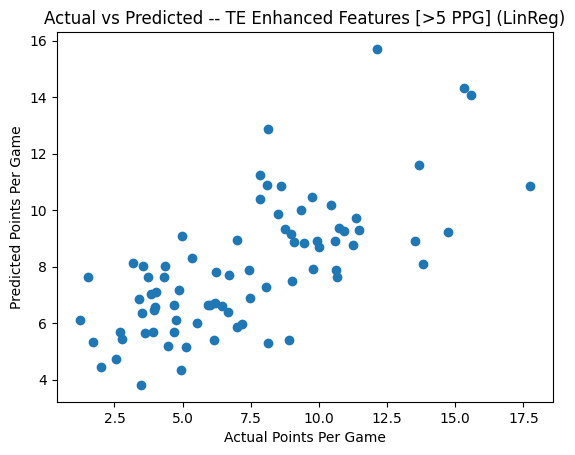

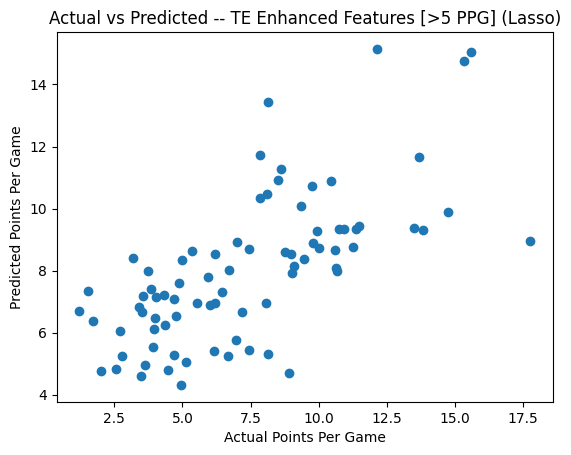

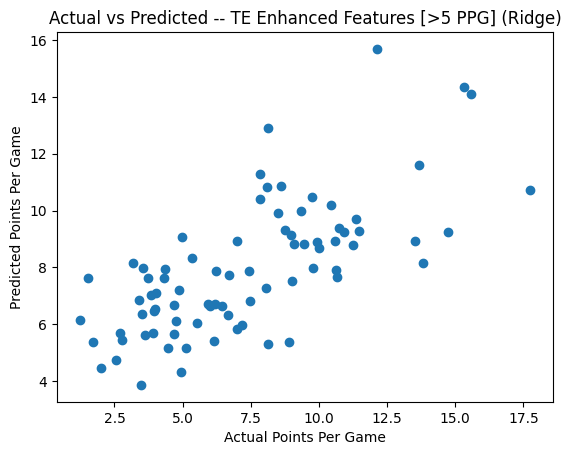

In [61]:
# Gets the features used in the final model
te_final_features = ['receptions', 'receiving_yards', 'receiving_tds',
                     'receiving_fumbles_lost', 'receiving_2pt_conversions',
                     'yptmpa', 'receiving_epa']

# Imports our models for final testing now that parameters have been selected
linear_reg_model = LinearRegression()
lasso_reg_model = LassoCV()
ridge_reg_model = RidgeCV()

# Selects the baselines features for the model
final_te_test_x_train = x_train[te_final_features]
final_te_test_x_test = x_test[te_final_features]

# Linear Regression fit
linear_reg_model.fit(final_te_test_x_train, y_train)
lin_reg_te_pred = linear_reg_model.predict(final_te_test_x_test)

# Lasso Regression fit
lasso_reg_model.fit(final_te_test_x_train, y_train)
lasso_reg_te_pred = lasso_reg_model.predict(final_te_test_x_test)

# Ridge Regression fit
ridge_reg_model.fit(final_te_test_x_train, y_train)
ridge_reg_te_pred = ridge_reg_model.predict(final_te_test_x_test)


# Calculates correlation for the models
print ("Linear Regression Correlation is: " + str(np.corrcoef(y_test, lin_reg_te_pred)[0][1]))
print ("Linear Regression MSE is: " + str(mean_squared_error(y_test, lin_reg_te_pred)))
print ("Lasso Regression Correlation is: " + str(np.corrcoef(y_test, lasso_reg_te_pred)[0][1]))
print ("Lasso Regression MSE is: " + str(mean_squared_error(y_test, lasso_reg_te_pred)))
print ("Ridge Regression Correlation is: " + str(np.corrcoef(y_test, ridge_reg_te_pred)[0][1]))
print ("Ridge Regression MSE is: " + str(mean_squared_error(y_test, ridge_reg_te_pred)))

# Plot actual vs predicted -- Linear Regression
fig, ax = plt.subplots()
ax.scatter(y_test, lin_reg_te_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- TE Enhanced Features [>5 PPG] (LinReg)')

plt.show()

# Plot actual vs predicted - Lasso Regression
fig, ax = plt.subplots()
ax.scatter(y_test, lasso_reg_te_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- TE Enhanced Features [>5 PPG] (Lasso)')

plt.show()

# Plot actual vs predicted - Ridge Regression
fig, ax = plt.subplots()
ax.scatter(y_test, ridge_reg_te_pred)

# Set axis labels
ax.set_xlabel('Actual Points Per Game')
ax.set_ylabel('Predicted Points Per Game')

# Set plot title
ax.set_title('Actual vs Predicted -- TE Enhanced Features [>5 PPG] (Ridge)')

plt.show()

Ridge and Linear Regression similar enough to a point where we use Ridge Regession to prevent overfitting in the future.

## **TE Final Model -- Ridge Regression of Baseline Features + 'yptmpa' and 'receiving_epa'**

In [ ]:
# Creates the mixture model for the qb stat prediction
final_input = pd.DataFrame(final_te_x)
final_mask = np.where(((final_input['fantasy_points_ppr']/final_input['games']) > 5), 1, 0)
players_to_predict = final_input.loc[final_mask == 1]

# Gets the features used in the final model
te_final_features = ['receptions', 'receiving_yards', 'receiving_tds',
                     'receiving_fumbles_lost', 'receiving_2pt_conversions',
                     'yptmpa', 'receiving_epa']

# Makes predictions off of our top players
final_te_model = RidgeCV()
final_te_model.fit(pd.DataFrame(te_x)[te_final_features], te_y)
predictions = final_te_model.predict(players_to_predict[te_final_features])

# Gets rankings of players in our list
player_ranks = np.argsort(predictions)[::-1]
output_player_ranks(player_ranks, 2022)

184    Travis Kelce
Name: player_name, dtype: object
635    George Kittle
Name: player_name, dtype: object
1112    Mark Andrews
Name: player_name, dtype: object
956    Dallas Goedert
Name: player_name, dtype: object
1312    T.J. Hockenson
Name: player_name, dtype: object
788    Evan Engram
Name: player_name, dtype: object
2288    Pat Freiermuth
Name: player_name, dtype: object
791    David Njoku
Name: player_name, dtype: object
1852    Cole Kmet
Name: player_name, dtype: object
600    Tyler Higbee
Name: player_name, dtype: object
984    Dalton Schultz
Name: player_name, dtype: object
1692    Juwan Johnson
Name: player_name, dtype: object
1539    Dawson Knox
Name: player_name, dtype: object
2359    Kyle Pitts
Name: player_name, dtype: object
590    Hunter Henry
Name: player_name, dtype: object
328    Darren Waller
Name: player_name, dtype: object
916    Tyler Conklin
Name: player_name, dtype: object
443    Austin Hooper
Name: player_name, dtype: object
1502    Noah Fant
Name: player_nam